In [1]:
import h5py
import numpy as np
import pandas as pd
from icecream import ic
import matplotlib.pyplot as plt
import matplotlib.widgets
import plotly.graph_objects as go
import plotly.subplots
import plotly.express as px
import retinapy.mea as mea
import torch
import itertools

In [2]:
%matplotlib widget

In [3]:
def fullprint(*args, **kwargs):
  from pprint import pprint
  opt = np.get_printoptions()
  np.set_printoptions(threshold=np.inf)
  pprint(*args, **kwargs)
  np.set_printoptions(**opt)

In [4]:
stimulus_path = '../data/ff_noise.h5'
recorded_stimulus_path = '../data/ff_recorded_noise.pickle.zip'
response_path = '../data/ff_spike_response.pickle'
#response_npz_path = 'D:/Complete_analysis/For_Kevin/FF_Noise_data'
electrode_freq = 17852.767845719834 # Hz
stimulus_switching_freq = 20 # Hz
stimulus_duration_mins = 20 # Noise file has 20min worth at 20 Hz
experiment_duration_mins = 15 # Recording only goes for 15min (different in some exps?).
experiment_duration_secs = experiment_duration_mins * 60 
stimulus_duration_secs = stimulus_duration_mins * 60
num_colors = 4

In [5]:
colormap = pd.DataFrame({
    'names':['Red', 'Green', 'Blue', 'UV', 'Sum'],
    'display_hex':['#ff0a0a', '#0aff0a', '#0a0aff', '#303030', '#0a0a0a']})
colormap

names display_hex
0    Red     #ff0a0a
1  Green     #0aff0a
2   Blue     #0a0aff
3     UV     #303030
4    Sum     #0a0a0a

In [6]:
interesting_cells = [20,]

In [7]:
with h5py.File(stimulus_path, 'r') as f:
    # the data has shape: [4, 24000, 10374]. This corresponds to 4 lights,
    # on-off pattern for 20min at 20 Hz (24000 periods), and 10374 boxes 
    # arranged over 2D screen space. In this experiment, only a single box
    # was used, hence the [:,0] access pattern.
    print(f.keys())
    stimulus_pattern = np.array(
        [ f['/Red_Noise'][:,0],
        f['/Green_Noise'][:,0],
        f['/Blue_Noise'][:,0],
        f['/UV_Noise'][:,0]]).T
print(f'shape: {stimulus_pattern.shape}')
assert stimulus_pattern.shape[0] == stimulus_duration_secs * stimulus_switching_freq
stimulus_pattern

<KeysViewHDF5 ['Blue_Noise', 'Green_Noise', 'Info', 'Red_Noise', 'UV_Noise']>
shape: (24000, 4)


array([[0, 1, 0, 0],
       [1, 1, 0, 0],
       [1, 1, 0, 1],
       ...,
       [0, 1, 1, 1],
       [1, 0, 1, 1],
       [0, 1, 0, 0]], dtype=int8)

In [8]:
rs = pd.read_pickle(recorded_stimulus_path)
rs.reset_index('Stimulus_index', drop=True)
recorded_stimulus = rs

In [9]:
response_data = pd.read_pickle(response_path)
print(f'Response data shape: {response_data.shape}',
      f'Response data index: {response_data.index.names}', sep='\n')
rec_name = 'Chicken_04_08_21_Phase_01'
response_data.xs(rec_name, level='Recording')
response_data.xs((1, 1485), level=('Stimulus ID', 'Cell index'))

Response data shape: (4417, 2)
Response data index: ['Cell index', 'Stimulus ID', 'Recording']


Kernel  \
Recording                                                                          
Chicken_06_08_21_2nd_Phase_00  [[72.0, 69.0, 71.0, 87.0], [71.0, 69.0, 71.0, ...   
Chicken_17_08_21_Phase_00      [[1.0, 1.0, 0.0, 0.0], [1.0, 1.0, 0.0, 0.0], [...   

                                                                          Spikes  
Recording                                                                         
Chicken_06_08_21_2nd_Phase_00  [191381, 345117, 499118, 903200, 913601, 10193...  
Chicken_17_08_21_Phase_00      [8614426, --, --, --, --, --, --, --, --, --, ...

In [10]:
#gdf = response_data.xs(1, level='Stimulus ID', drop_level=True).groupby('Recording')
#r1 = next(iter(gdf))
#r1[0]
df = response_data.reset_index(level=('Cell index', 'Stimulus ID'))
r1 = next(df.iterrows())
r1[0]
response_data

Kernel  \
Cell index Stimulus ID Recording                                                                      
25         1           Chicken_04_08_21_Phase_01  [[2470.0, 2487.0, 2473.0, 2509.0], [2465.0, 24...   
40         1           Chicken_04_08_21_Phase_01  [[2360.0, 2598.0, 2418.0, 2413.0], [2362.0, 25...   
41         1           Chicken_04_08_21_Phase_01  [[2212.0, 2325.0, 2348.0, 2330.0], [2216.0, 23...   
50         1           Chicken_04_08_21_Phase_01  [[1923.0, 1797.0, 1833.0, 1794.0], [1922.0, 18...   
52         1           Chicken_04_08_21_Phase_01  [[2267.0, 2299.0, 2236.0, 2181.0], [2273.0, 23...   
...                                                                                             ...   
287        1           Chicken_21_08_21_Phase_00  [[21.0, 22.0, 27.0, 21.0], [21.0, 22.0, 27.0, ...   
317        1           Chicken_21_08_21_Phase_00  [[31.0, 26.0, 31.0, 30.0], [32.0, 25.0, 31.0, ...   
421        1           Chicken_21_08_21_Phase_00  [[18.0, 29.0, 26.0, 26.0], [19.0, 28.0, 25.0, ...   
553        1           Chicken_21_08_21_Phase_00  [[11.0, 15.0, 18.0, 12.0], [12.0, 15.0, 18.0, ...   
591        1           Chicken_21_08_21_Phase_00  [[26.0, 20.0, 21.0, 19.0], [26.0, 20.0, 21.0, ...   

                                                                                             Spikes  
Cell index Stimulus ID Recording                                                                     
25         1           Chicken_04_08_21_Phase_01  [2642, 3648, 4161, 4396, 5054, 6397, 12179, 46...  
40         1           Chicken_04_08_21_Phase_01  [4044, 4067, 4103, 4142, 4447, 4823, 5271, 146...  
41         1           Chicken_04_08_21_Phase_01  [1177, 1226, 2077, 2523, 3477, 3528, 4472, 458...  
50         1           Chicken_04_08_21_Phase_01  [4600, 4739, 4936, 5164, 5421, 5636, 5980, 624...  
52         1           Chicken_04_08_21_Phase_01  [4430, 4629, 4902, 5157, 5480, 5908, 6231, 137...  
...                                                                                             ...  
287        1           Chicken_21_08_21_Phase_00  [158197, 604054, 893662, 3012719, 4796892, 513...  
317        1           Chicken_21_08_21_Phase_00  [70662, 94427, 186141, 1333032, 1934783, 21378...  
421        1           Chicken_21_08_21_Phase_00  [84603, 164502, 344880, 694259, 894463, 117019...  
553        1           Chicken_21_08_21_Phase_00  [258150, 311192, 433684, 1130586, 1492330, 408...  
591        1           Chicken_21_08_21_Phase_00  [10889, 63520, 89740, 96414, 130807, 445529, 5...  

[4417 rows x 2 columns]

## Notes on the dataframe index

- I think that the 'Stimulus ID' sub-index is mostly 1. Chicken_06_08_21_Phase_00 uses stimulus 7, taking up 4417 rows in the table.
- Marvin mentioned that the recording done on 2021/08/17 labeled **'Chicken_17_08_21_Phase_00'** was a high-quality recording session.
- Some recording sessions were long enough to do multiple experiments. In these cases, there are multiple 'phases', such as 'Chicken_04_08_21_Phase_00' and 'Chicken_04_08_21_Phase_01'.

In [19]:
#rec_name ='Chicken_17_08_21_Phase_00'
rec_name = "Chicken_06_08_21_2nd_Phase_00"
recording1 = response_data.xs((rec_name, 1), level=('Recording', 'Stimulus ID'))
#response_data.iloc[4].Spikes.compressed()[0:4]
ma = response_data.xs(rec_name, level='Recording').reset_index('Stimulus ID').iloc[4]
ma

Stimulus ID                                                    1
Kernel         [[1834.0, 1835.0, 1831.0, 1735.0], [1818.0, 18...
Spikes         [141, 13133, 14176, 22501, 22814, 26568, 27224...
Name: 91, dtype: object

In [20]:
def get_recording_list():
    rec_list = response_data.index.get_level_values('Recording').unique().tolist()
    return rec_list
 
rec_list = ['Chicken_04_08_21_Phase_01',
            'Chicken_04_08_21_Phase_02',
            'Chicken_05_08_21_Phase_00',
            'Chicken_05_08_21_Phase_01',
            'Chicken_06_08_21_2nd_Phase_00',
            'Chicken_06_08_21_Phase_00',
            'Chicken_11_08_21_Phase_00',
            'Chicken_12_08_21_Phase_00',
            'Chicken_12_08_21_Phase_02',
            'Chicken_13_08_21_Phase_00',
            'Chicken_13_08_21_Phase_01',
            'Chicken_14_08_21_Phase_00',
            'Chicken_17_08_21_Phase_00',
            'Chicken_19_08_21_Phase_00',
            'Chicken_19_08_21_Phase_01',
            'Chicken_20_08_21_Phase_00',
            'Chicken_21_08_21_Phase_00']  

rec_name_to_id_map = {i:n for i,n in enumerate(rec_list)}

def rec_name_to_id(rec_name):
    return rec_name_to_id_map(rec_name)
    

## Kernel calculation
Using downsampled stimulus method.

In [21]:
a = torch.tensor([[0, 1], [1, 7], [4, 2], [4, 4]])
b = torch.tensor([1, 2, 3, 4])
torch.concat((a, torch.unsqueeze(b, dim=-1)), dim=1)



tensor([[0, 1, 1],
        [1, 7, 2],
        [4, 2, 3],
        [4, 4, 4]])

In [22]:
def factors_sorted_by_sum(n, limit):
    """
    Calulates factor decomposition with sort and limit.

    This method is used to choose downsampling factors when a single factor
    is too large.

    The decompositions are sorted by the sum of the factors. Only factor
    decompositions where all factors are below the given limit are returned.
    """
    def _factors(n):
        res = [(n,),]
        f1 = n // 2
        while(f1 > 1):
            f2, mod = divmod(n,f1)
            if not mod:
                res.append((f1, f2)) 
                sub_factors = [a+b for (a,b) in
                        itertools.product(_factors(f1), _factors(f2))]
                res.extend(sub_factors)
            f1 -= 1
        return res
    factors = list(set(_factors(n)))
    factors_under = [f for f in factors if max(f) <= limit]
    sorted_by_count = sorted(factors_under, key = lambda x : len(x))
    return sorted_by_count

factors_sorted_by_sum(64,11)

[(8, 8),
 (4, 8, 2),
 (4, 4, 4),
 (8, 4, 2),
 (2, 4, 8),
 (8, 2, 4),
 (2, 8, 4),
 (4, 2, 8),
 (2, 2, 4, 4),
 (4, 2, 4, 2),
 (8, 2, 2, 2),
 (2, 4, 4, 2),
 (4, 2, 2, 4),
 (4, 4, 2, 2),
 (2, 2, 2, 8),
 (2, 4, 2, 4),
 (2, 8, 2, 2),
 (2, 2, 8, 2),
 (2, 2, 2, 2, 4),
 (2, 4, 2, 2, 2),
 (2, 2, 2, 4, 2),
 (2, 2, 4, 2, 2),
 (4, 2, 2, 2, 2),
 (2, 2, 2, 2, 2, 2)]

In [23]:
def calculate_kernel(stimulus, spikes, stimulus_freq):
    # Don't forget to unwrap the masked array
    spikes = spikes.compressed()
    snippets = mea.spike_snippets(stimulus, spikes, 
                                  stimulus_freq, electrode_freq,
                                  total_len=2000, 
                                  post_spike_len=1000)
    kernel = np.sum(snippets, axis=0)
    return kernel

In [24]:
def time_plot(stimulus_data, spike_times):
    """
    Args:
        stimulus_data (np.ndarray): ndarray of shape (4,24000) with values 
            in {0,1} representing stimulus.
        spike_data: (np.array): np.ndarray of spike times (in electrode sample periods)
    """
    num_seconds = stimulus_duration_secs
    xs = np.arange(0, num_seconds, 1/stimulus_freq)
    #xs2 = np.arange(0, num_seconds, 1/electrode_freq)
    num_rows = 5
    spike_times = spike_times / electrode_freq
    color_sum = np.sum(stimulus_data, axis=0)

    fig = plotly.subplots.make_subplots(rows=num_rows, shared_xaxes=True, vertical_spacing=0.02)
    # go.Figure()
    def add_stim_trace(stim_data, row, color, convolve_win=4):
        smoothing_kernel = np.concatenate([np.ones(convolve_win), np.zeros(convolve_win)])/convolve_win
        #color = colormap.loc[i]['display_hex']
        scolor = '#707070'
        trace1 = go.Scatter(x=xs, y=stim_data, line_color=color, line_shape='hv')
        trace2 = go.Scatter(x=xs,  y=np.convolve(stim_data, smoothing_kernel), 
                            line_color=scolor, line_shape='spline')
        fig.add_trace(trace1, row=row, col=1)
        fig.add_trace(trace2, row=row, col=1)
        
    add_stim_trace(color_sum, row=1, color=colormap.loc[4]['display_hex'])
    for i in range(num_colors): 
        add_stim_trace(stimulus_data[i], row=i+2, color=colormap.loc[i]['display_hex'])
    spike_trace = go.Scatter(x=spike_times, y=np.ones(xs.shape), mode='markers',  name='markers', marker=dict(color='#0a0a0a'))
    fig.add_trace(spike_trace, row=1, col=1)
    fig.update_layout(autosize=False, 
                      height=600,
                      width=700,
                      margin=dict(l=1, r=1, b=1, t=1, pad=1),
                      yaxis_range=[-0.2, 4.5],
                      yaxis_fixedrange=True,
                      xaxis_range=[-10, num_seconds+10])
    return fig

In [25]:
def stim_sum_plot(stimulus, win_sec=10):
    convolve_win = win_sec * stimulus_switching_freq
    xs = np.arange(0, stimulus.shape[0]) * 1/stimulus_freq
    colour_sum = np.sum(stimulus, axis=0)
    smoothing_kernel = np.concatenate([np.ones(convolve_win), 
                                       np.zeros(convolve_win)])/convolve_win
    ys = np.convolve(colour_sum, smoothing_kernel)
    fig = go.Figure()
    trace_sum = go.Scatter(x=xs,  y=np.convolve(colour_sum, smoothing_kernel))
    fig.add_trace(trace_sum)
    for i in range(num_colors):
        trace_i = go.Scatter(x=xs,  y=np.convolve(stimulus[i], smoothing_kernel))
        fig.add_trace(trace_i)
    fig.update_layout(autosize=False, 
                      height=500,
                      width=700,
                     )#margin=dict(l=1, r=1, b=10, t=1, pad=1))
    fig.show()
    
def kernel_plot(kernel):
    fig = go.Figure()
    assert kernel.shape[0] == 2000 # 2 seconds of miliseconds
    xs = np.arange(kernel.shape[0])
    # Shift the x-axis to have zero in the middle.
    xs -= xs.shape[0] // 2
    for c in range(4):
        fig.add_trace(go.Scatter(x=xs, 
                                 y=kernel[:,c], 
                                 line_color=colormap.loc[c]['display_hex'], 
                                 mode='lines'))
    fig.add_vline(x=-100, line_width=2, line_dash='dot', line_color='grey',
                  annotation_text='-100ms', annotation_position='bottom right')
    fig.update_layout(autosize=False,
                      height=400,
                      width=800,
                      margin=dict(l=1, r=1, b=1, t=25, pad=1),
                      yaxis_fixedrange=True,
                      showlegend=False,
                      title='Kernel',
                      title_x=0.5,
                      title_pad=dict(l=1, r=1, b=10, t=1),
                      xaxis={'title':'time (ms), with spike at 0'},
                      yaxis={'title':'summed responses'} )
    return fig

def spike_rate_plot(spikes, win_sec=10):
    num_bins = int(experiment_duration_secs / win_sec)
    spike_times = spikes / electrode_freq
    fig = px.histogram(spike_times, nbins=num_bins)
    fig.update_layout(autosize=False,
                      height=300,
                      width=800,
                      margin=dict(l=1, r=1, b=1, t=25, pad=1),
                      showlegend=False,
                      title=f'Spike counts ({win_sec} sec bins)', 
                      title_pad=dict(l=1, r=1, b=10, t=1),
                      title_x=0.5,
                      yaxis_fixedrange=True)
    return fig

(idx: 202. id: 664. Spike count: 1763 (1.96, per second)


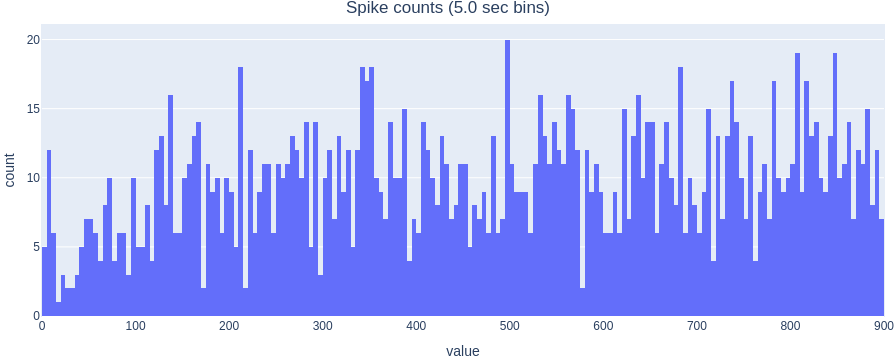

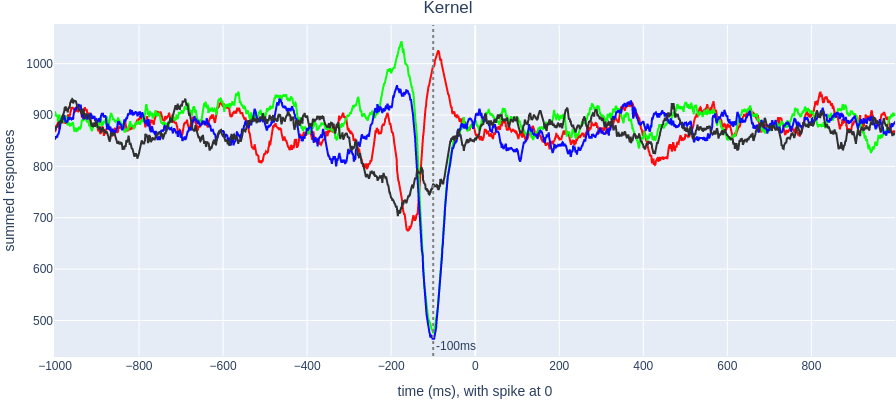

(idx: 203. id: 669. Spike count: 124 (0.14, per second)


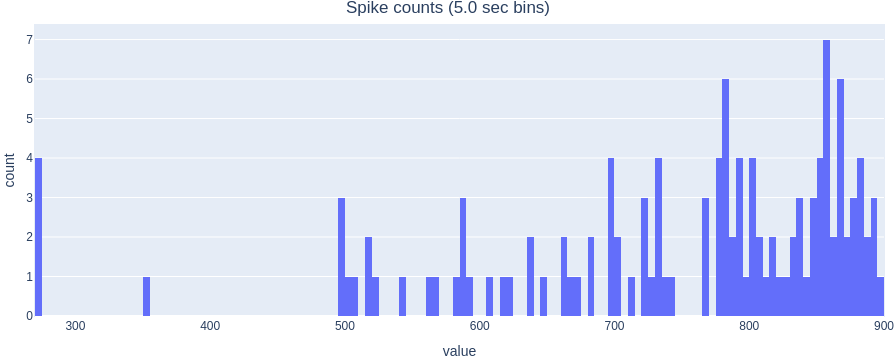

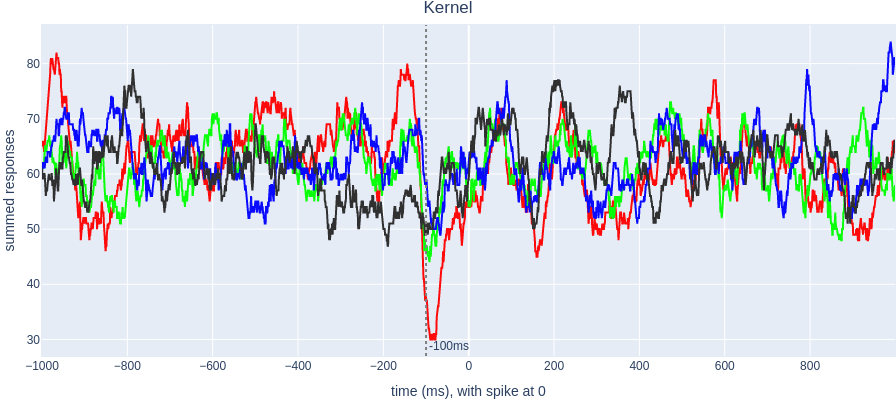

(idx: 204. id: 670. Spike count: 75 (0.08, per second)


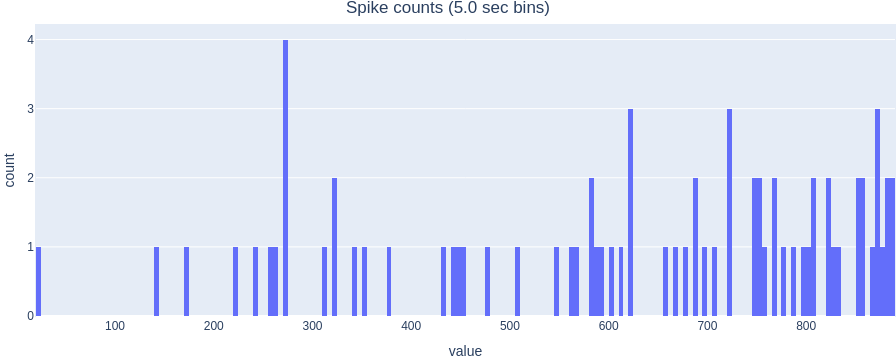

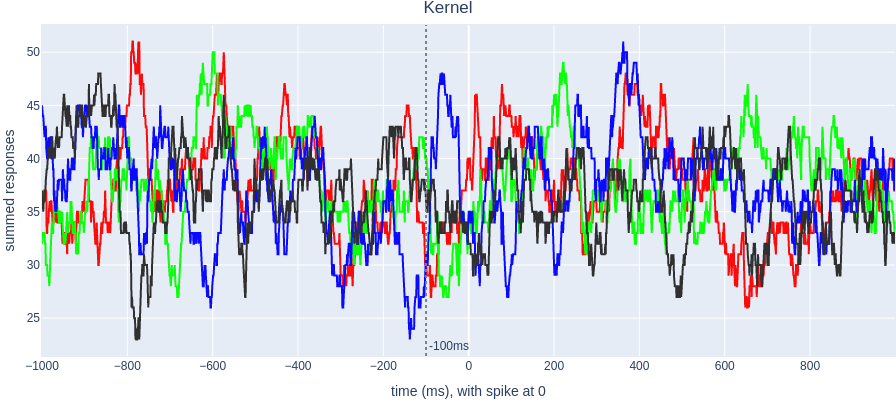

(idx: 205. id: 674. Spike count: 1198 (1.33, per second)


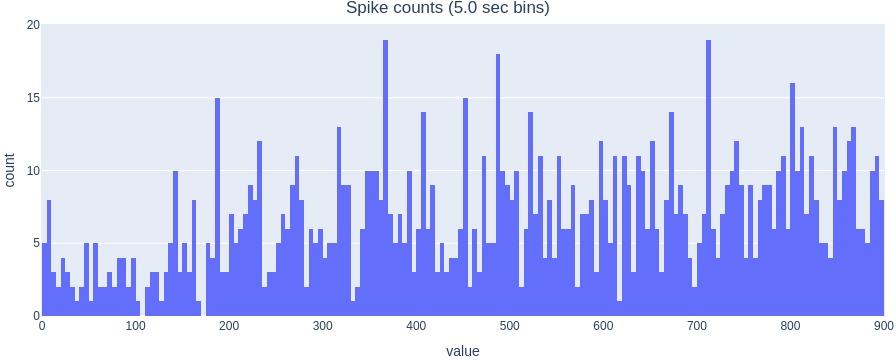

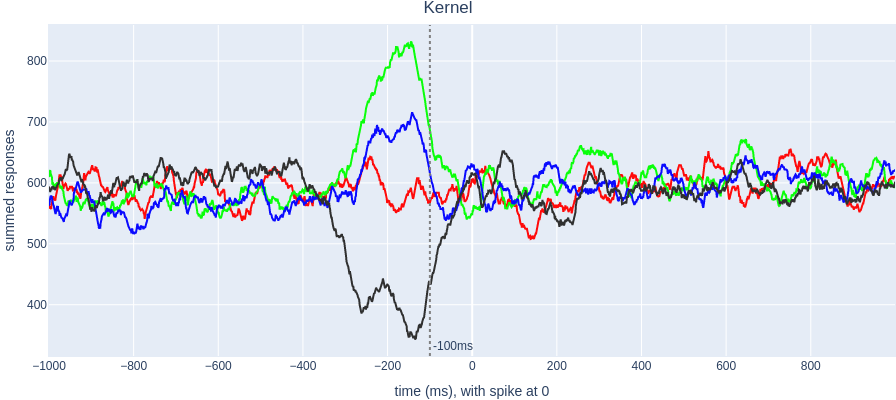

(idx: 206. id: 679. Spike count: 376 (0.42, per second)


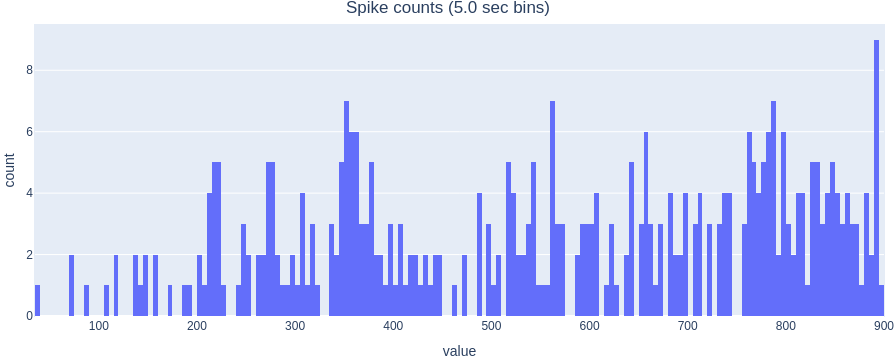

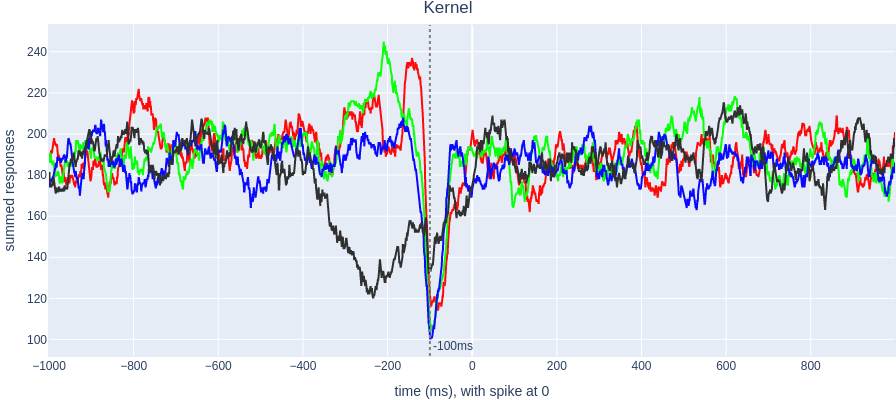

(idx: 207. id: 680. Spike count: 205 (0.23, per second)


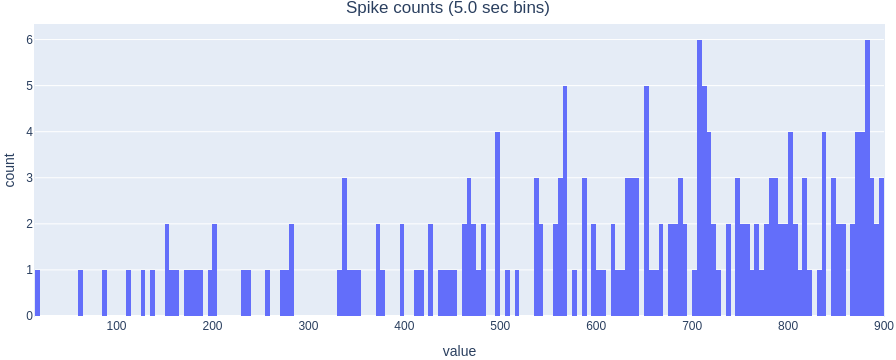

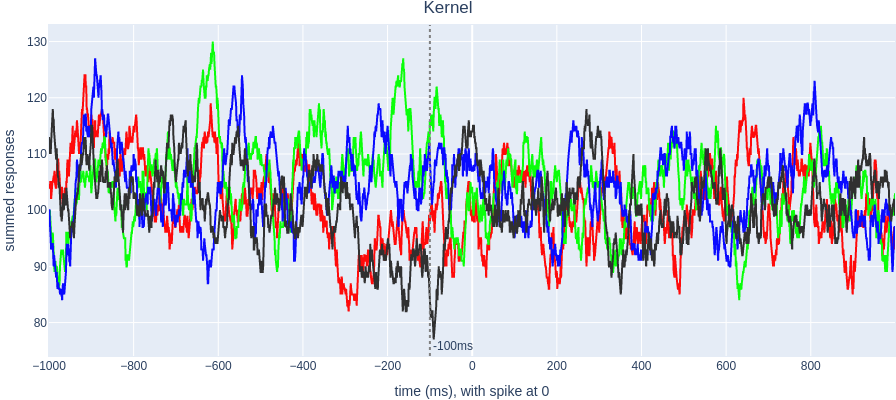

(idx: 208. id: 682. Spike count: 1076 (1.20, per second)


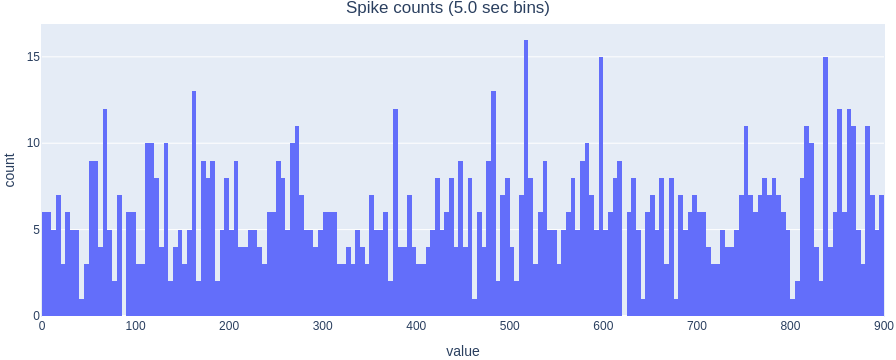

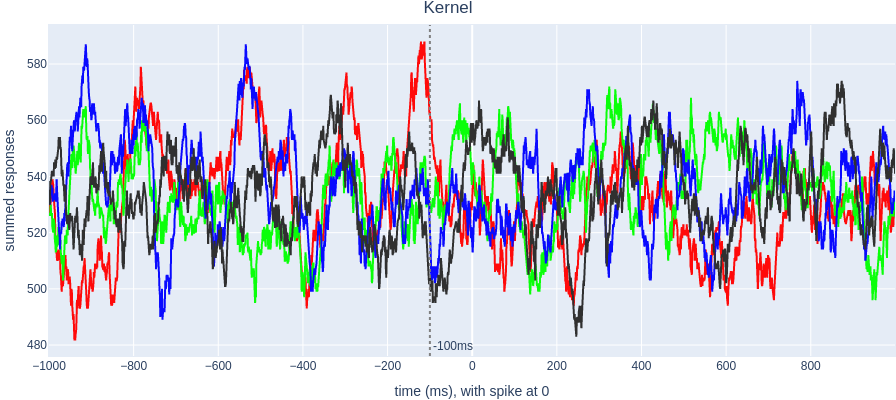

(idx: 209. id: 684. Spike count: 1040 (1.16, per second)


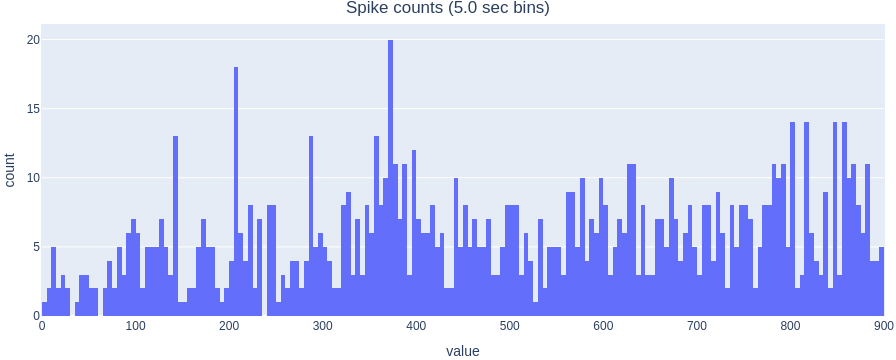

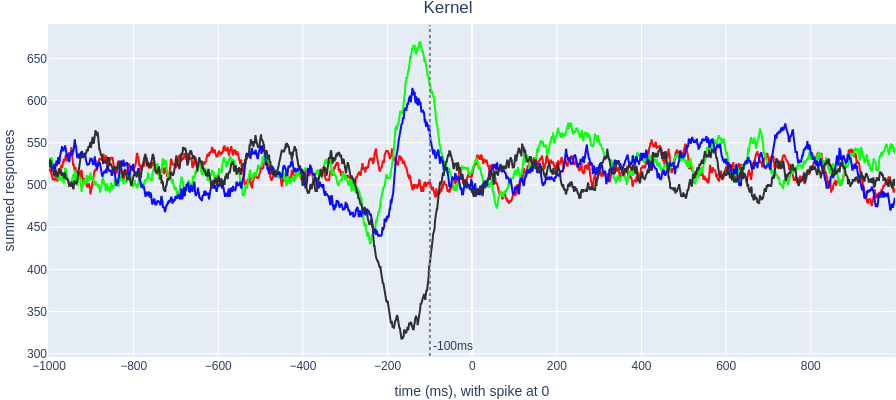

In [33]:
def plot_all(iloc):
    data = recording1.iloc[iloc]#9#13#15#18#21#25#27
    spikes = data['Spikes']
    print(f'(idx: {iloc}. id: {data.name}. Spike count: {spikes.count()} ({spikes.count()/experiment_duration_secs:.2f}, per second)')
    spike_rate_plot(spikes, win_sec=5.0).show()
    kernel1 = data['Kernel']
    kernel_plot(kernel1).show()
    #kernel2 = calculate_kernel(stimulus, spikes, stimulus_freq)
    #kernel_plot(kernel2).show()
    #plot1 = time_plot(colour_noise, spikes); plot1.show()
    #px.line(x=np.arange(2000), y=selected_data1.loc[14]['Kernel'][:,0])
    #stim_sum_plot(colour_noise)
#print(recording1.shape)
#for i in range(1000):
#    if recording1.iloc[i].name == 664:
#        print(i)
for i in range(202, 210):
    plot_all(i)